In [1]:
!nvidia-smi

Thu May 19 09:28:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 30%   48C    P8    20W / 370W |   2654MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchmetrics

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import albumentations as A
import torchvision
import torchvision.transforms as transforms
import albumentations.pytorch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from torchmetrics.functional import jaccard_index

In [4]:
torch.__version__

'1.11.0+cu113'

## Data

In [5]:
label_path = "./PH2Dataset/clinical_diagnosis_labels.csv"
df = pd.read_csv(label_path)
subject_list = list(df["Name"])

In [6]:
def train_valid_test_split(folder, train_ratio, valid_ratio, test_ratio):
    
    normal_nevus = 0
    atypical_nevus = 0
    melanoma = 0
    
    train_files=[]
    valid_files=[]
    test_files=[]
    
    for file in folder:
        if normal_nevus <= 80:  
            if normal_nevus < 80*train_ratio:
                train_files.append(file)
            elif normal_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            normal_nevus += 1
            
        elif atypical_nevus <= 80:
            if atypical_nevus < 80*train_ratio:
                train_files.append(file)
            elif atypical_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            atypical_nevus += 1
        
        else:
            if melanoma < 40*train_ratio:
                train_files.append(file)
            elif melanoma < 40*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            melanoma += 1
            
    return train_files, valid_files, test_files

In [7]:
config = {
    "model": "fcn_aug",
    "image_height": 192,
    "image_width": 256,
    "initial_lr": 1e-4,
    "n_epochs": 50,
    "batch_size": 2
}

In [8]:
train_files, valid_files, test_files = train_valid_test_split(subject_list, 0.8, 0.1, 0.1)

In [9]:
print(len(train_files), len(valid_files), len(test_files))

160 20 20


In [10]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in train_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

64 64 32


In [11]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in valid_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [12]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in test_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [13]:
train_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    A.augmentations.transforms.VerticalFlip(p=0.5),
    A.augmentations.geometric.rotate.Rotate(),
    A.pytorch.transforms.ToTensorV2(),
])

test_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.pytorch.transforms.ToTensorV2(),
])

In [14]:
class PH2Dataset(Dataset):
    def __init__(self, file_list, transforms):
       
        self.dataset_path = "./PH2Dataset/PH2 Dataset images/"
        self.subject_list = file_list
        self.transforms = transforms
    
    def __len__(self):
       
        return len(self.subject_list)

    def __getitem__(self, idx):
       
        subject = self.subject_list[idx]
        
        img_folder = subject + "_Dermoscopic_Image"
        img_filename = subject + ".bmp"
        mask_folder =  subject + "_lesion"
        mask_filename =  mask_folder + ".bmp"
        
        image_path = os.path.join(self.dataset_path, subject, img_folder, img_filename)
        mask_path = os.path.join(self.dataset_path, subject, mask_folder, mask_filename)
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,0)
          
   
        if self.transforms is not None:
          
            masks = []
            masks.append(mask)
            transformed = self.transforms(image=image, masks = masks)
            image = transformed["image"] / 255  # [0, 255] (int) -> [0, 1] (float)
            mask = torch.tensor(transformed["masks"][0] / 255).unsqueeze(0).type(torch.float32)  # [H, W] (int) -> [1, H, W] (float) 
        
        return image, mask

In [15]:
train_set = PH2Dataset(train_files, transforms=train_tfm)
valid_set = PH2Dataset(valid_files, transforms=test_tfm)
test_set = PH2Dataset(test_files, transforms=test_tfm)

torch.Size([192, 256, 3])
tensor([[[0.7647, 0.6196, 0.5294],
         [0.7725, 0.6314, 0.5451],
         [0.7647, 0.6235, 0.5451],
         ...,
         [0.8157, 0.6431, 0.5098],
         [0.8196, 0.6431, 0.5176],
         [0.8000, 0.6353, 0.5098]],

        [[0.7569, 0.6078, 0.5176],
         [0.7725, 0.6235, 0.5333],
         [0.7725, 0.6196, 0.5294],
         ...,
         [0.8078, 0.6314, 0.5020],
         [0.8157, 0.6314, 0.5216],
         [0.8118, 0.6353, 0.5137]],

        [[0.7608, 0.6118, 0.5098],
         [0.7686, 0.6235, 0.5255],
         [0.7765, 0.6235, 0.5255],
         ...,
         [0.8039, 0.6275, 0.5059],
         [0.8000, 0.6275, 0.5098],
         [0.8118, 0.6392, 0.5098]],

        ...,

        [[0.8118, 0.6902, 0.5647],
         [0.8000, 0.6824, 0.5569],
         [0.7725, 0.6588, 0.5451],
         ...,
         [0.8980, 0.7725, 0.6549],
         [0.9098, 0.7882, 0.6745],
         [0.9059, 0.7882, 0.6784]],

        [[0.8314, 0.6980, 0.5804],
         [0.8157, 0.6

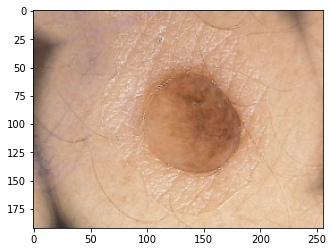

In [16]:
img = train_set[1][0].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

torch.Size([192, 256, 1])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])


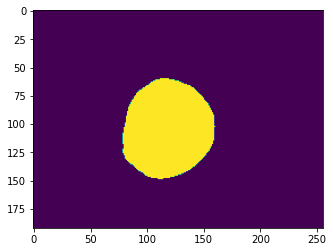

In [17]:
img = train_set[1][1].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

## Model

In [31]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

In [32]:
from torchvision.models.segmentation.fcn import FCNHead
device = "cuda" if torch.cuda.is_available() else "cpu"

outChannel = 1

""" DeepLab V3 """
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model.classifier = DeepLabHead(2048, outChannel)

""" FCN """
model = models.segmentation.fcn_resnet101(pretrained=True)
model.classifier = FCNHead(2048, outChannel)
model = model.to(device)

In [33]:
# BCEwithlogitsloss = BCELoss + Sigmoid
loss_func = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=config["initial_lr"])

train_steps = len(train_set) / config["batch_size"]
valid_steps = len(valid_set) / config["batch_size"]
test_steps = len(valid_set) / config["batch_size"]

In [34]:
print("Training the network...")
best_loss = float("inf")
train_loss_history = []
train_iou_history = []
valid_loss_history = []
valid_iou_history = []

for epoch in range(config["n_epochs"]):
    
    model.train()
    
    total_train_loss = 0
    total_train_iou = 0
    total_valid_loss = 0
    total_valid_iou = 0
    
    
    for (i, (x, y)) in enumerate(tqdm(train_loader)):
        
        (x, y) = (x.to(device), y.to(device))

        outputs = model(x)
        pred = torch.sigmoid(outputs['out'])                
        loss = loss_func(outputs['out'], y)
        iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss
        total_train_iou += iou
           
    train_loss = total_train_loss / train_steps
    train_loss_history.append(train_loss.cpu().detach().numpy())
    train_iou = total_train_iou / train_steps
    train_iou_history.append(train_iou.cpu().detach().numpy())
    print(f'[ Train | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}')
    
    with torch.no_grad():
       
        model.eval()

        for (x, y) in tqdm(valid_loader):
          
            (x, y) = (x.to(device), y.to(device))
           
            outputs = model(x)
            pred = torch.sigmoid(outputs['out'])                
            loss = loss_func(outputs['out'], y)
            iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
        
            total_valid_loss += loss
            total_valid_iou += iou
            
        
    
    valid_loss = total_valid_loss / valid_steps
    valid_loss_history.append(valid_loss.cpu().detach().numpy())
    valid_iou = total_valid_iou / valid_steps
    valid_iou_history.append(valid_iou.cpu().detach().numpy())
    print(f'[ Valid | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')
    
    # save models
    if valid_loss < best_loss:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                }, f'{config["model"]}_best.ckpt')

        best_loss = valid_loss

Training the network...


100%|██████████| 80/80 [00:07<00:00, 10.18it/s]


[ Train | 001/050 ] loss = 0.28829 iou = 0.77324


100%|██████████| 10/10 [00:00<00:00, 41.49it/s]


[ Valid | 001/050 ] loss = 0.21813 iou = 0.83511
Best model found at epoch 0, saving model


100%|██████████| 80/80 [00:07<00:00, 10.35it/s]


[ Train | 002/050 ] loss = 0.18221 iou = 0.85239


100%|██████████| 10/10 [00:00<00:00, 26.45it/s]


[ Valid | 002/050 ] loss = 0.20632 iou = 0.86498
Best model found at epoch 1, saving model


100%|██████████| 80/80 [00:07<00:00, 10.87it/s]


[ Train | 003/050 ] loss = 0.13593 iou = 0.88542


100%|██████████| 10/10 [00:00<00:00, 37.31it/s]


[ Valid | 003/050 ] loss = 0.12419 iou = 0.89316
Best model found at epoch 2, saving model


100%|██████████| 80/80 [00:07<00:00, 10.36it/s]


[ Train | 004/050 ] loss = 0.14728 iou = 0.87770


100%|██████████| 10/10 [00:00<00:00, 19.10it/s]


[ Valid | 004/050 ] loss = 0.17527 iou = 0.86462


100%|██████████| 80/80 [00:07<00:00, 10.51it/s]


[ Train | 005/050 ] loss = 0.12494 iou = 0.89991


100%|██████████| 10/10 [00:00<00:00, 30.30it/s]


[ Valid | 005/050 ] loss = 0.19335 iou = 0.86150


100%|██████████| 80/80 [00:07<00:00, 10.14it/s]


[ Train | 006/050 ] loss = 0.10626 iou = 0.91039


100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


[ Valid | 006/050 ] loss = 0.13129 iou = 0.89892


100%|██████████| 80/80 [00:07<00:00, 10.15it/s]


[ Train | 007/050 ] loss = 0.09802 iou = 0.91293


100%|██████████| 10/10 [00:00<00:00, 23.14it/s]


[ Valid | 007/050 ] loss = 0.14287 iou = 0.86973


100%|██████████| 80/80 [00:07<00:00, 10.43it/s]


[ Train | 008/050 ] loss = 0.08458 iou = 0.92349


100%|██████████| 10/10 [00:00<00:00, 24.42it/s]


[ Valid | 008/050 ] loss = 0.12494 iou = 0.89005


100%|██████████| 80/80 [00:07<00:00, 10.17it/s]


[ Train | 009/050 ] loss = 0.07560 iou = 0.92850


100%|██████████| 10/10 [00:00<00:00, 27.36it/s]


[ Valid | 009/050 ] loss = 0.12180 iou = 0.88665
Best model found at epoch 8, saving model


100%|██████████| 80/80 [00:08<00:00,  9.89it/s]


[ Train | 010/050 ] loss = 0.12419 iou = 0.89060


100%|██████████| 10/10 [00:00<00:00, 30.50it/s]


[ Valid | 010/050 ] loss = 0.18923 iou = 0.85171


100%|██████████| 80/80 [00:07<00:00, 10.22it/s]


[ Train | 011/050 ] loss = 0.10390 iou = 0.90942


100%|██████████| 10/10 [00:00<00:00, 28.64it/s]


[ Valid | 011/050 ] loss = 0.16526 iou = 0.86676


100%|██████████| 80/80 [00:07<00:00, 10.25it/s]


[ Train | 012/050 ] loss = 0.10639 iou = 0.90795


100%|██████████| 10/10 [00:00<00:00, 28.19it/s]


[ Valid | 012/050 ] loss = 0.16882 iou = 0.86675


100%|██████████| 80/80 [00:07<00:00, 10.54it/s]


[ Train | 013/050 ] loss = 0.08431 iou = 0.92108


100%|██████████| 10/10 [00:00<00:00, 18.51it/s]


[ Valid | 013/050 ] loss = 0.12563 iou = 0.89157


100%|██████████| 80/80 [00:07<00:00, 10.10it/s]


[ Train | 014/050 ] loss = 0.08750 iou = 0.92137


100%|██████████| 10/10 [00:00<00:00, 31.35it/s]


[ Valid | 014/050 ] loss = 0.27341 iou = 0.86075


100%|██████████| 80/80 [00:07<00:00, 10.22it/s]


[ Train | 015/050 ] loss = 0.08322 iou = 0.92041


100%|██████████| 10/10 [00:00<00:00, 30.01it/s]


[ Valid | 015/050 ] loss = 0.18291 iou = 0.84535


100%|██████████| 80/80 [00:09<00:00,  8.13it/s]


[ Train | 016/050 ] loss = 0.07832 iou = 0.92849


100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


[ Valid | 016/050 ] loss = 0.13508 iou = 0.88905


100%|██████████| 80/80 [00:11<00:00,  6.88it/s]


[ Train | 017/050 ] loss = 0.07186 iou = 0.92943


100%|██████████| 10/10 [00:00<00:00, 11.49it/s]


[ Valid | 017/050 ] loss = 0.12456 iou = 0.89259


100%|██████████| 80/80 [00:11<00:00,  7.09it/s]


[ Train | 018/050 ] loss = 0.06339 iou = 0.93466


100%|██████████| 10/10 [00:00<00:00, 31.01it/s]


[ Valid | 018/050 ] loss = 0.11554 iou = 0.89556
Best model found at epoch 17, saving model


100%|██████████| 80/80 [00:10<00:00,  7.96it/s]


[ Train | 019/050 ] loss = 0.06373 iou = 0.93663


100%|██████████| 10/10 [00:00<00:00, 21.79it/s]


[ Valid | 019/050 ] loss = 0.14299 iou = 0.88452


100%|██████████| 80/80 [00:09<00:00,  8.41it/s]


[ Train | 020/050 ] loss = 0.09222 iou = 0.91103


100%|██████████| 10/10 [00:00<00:00, 12.10it/s]


[ Valid | 020/050 ] loss = 0.15444 iou = 0.85545


100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


[ Train | 021/050 ] loss = 0.07257 iou = 0.93095


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


[ Valid | 021/050 ] loss = 0.10133 iou = 0.91974
Best model found at epoch 20, saving model


100%|██████████| 80/80 [00:09<00:00,  8.30it/s]


[ Train | 022/050 ] loss = 0.07521 iou = 0.92913


100%|██████████| 10/10 [00:00<00:00, 17.17it/s]


[ Valid | 022/050 ] loss = 0.11562 iou = 0.90228


100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


[ Train | 023/050 ] loss = 0.06710 iou = 0.93267


100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


[ Valid | 023/050 ] loss = 0.13246 iou = 0.89359


100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


[ Train | 024/050 ] loss = 0.06064 iou = 0.93844


100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


[ Valid | 024/050 ] loss = 0.12017 iou = 0.90611


100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


[ Train | 025/050 ] loss = 0.05829 iou = 0.94161


100%|██████████| 10/10 [00:01<00:00,  9.77it/s]


[ Valid | 025/050 ] loss = 0.11221 iou = 0.91652


100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


[ Train | 026/050 ] loss = 0.05901 iou = 0.94010


100%|██████████| 10/10 [00:00<00:00, 13.38it/s]


[ Valid | 026/050 ] loss = 0.11535 iou = 0.90836


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


[ Train | 027/050 ] loss = 0.05824 iou = 0.93976


100%|██████████| 10/10 [00:00<00:00, 22.20it/s]


[ Valid | 027/050 ] loss = 0.09701 iou = 0.92190
Best model found at epoch 26, saving model


100%|██████████| 80/80 [00:09<00:00,  8.10it/s]


[ Train | 028/050 ] loss = 0.05210 iou = 0.94655


100%|██████████| 10/10 [00:00<00:00, 25.70it/s]


[ Valid | 028/050 ] loss = 0.13811 iou = 0.89495


100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


[ Train | 029/050 ] loss = 0.05821 iou = 0.94030


100%|██████████| 10/10 [00:00<00:00, 16.91it/s]


[ Valid | 029/050 ] loss = 0.12435 iou = 0.90220


100%|██████████| 80/80 [00:11<00:00,  7.15it/s]


[ Train | 030/050 ] loss = 0.16887 iou = 0.86331


100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


[ Valid | 030/050 ] loss = 0.18998 iou = 0.86523


100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


[ Train | 031/050 ] loss = 0.13570 iou = 0.89157


100%|██████████| 10/10 [00:00<00:00, 16.19it/s]


[ Valid | 031/050 ] loss = 0.21541 iou = 0.82713


100%|██████████| 80/80 [00:11<00:00,  7.20it/s]


[ Train | 032/050 ] loss = 0.10684 iou = 0.90660


100%|██████████| 10/10 [00:00<00:00, 11.57it/s]


[ Valid | 032/050 ] loss = 0.15783 iou = 0.87201


100%|██████████| 80/80 [00:11<00:00,  7.13it/s]


[ Train | 033/050 ] loss = 0.08070 iou = 0.92376


100%|██████████| 10/10 [00:00<00:00, 18.18it/s]


[ Valid | 033/050 ] loss = 0.14340 iou = 0.87897


100%|██████████| 80/80 [00:09<00:00,  8.26it/s]


[ Train | 034/050 ] loss = 0.07733 iou = 0.92734


100%|██████████| 10/10 [00:00<00:00, 26.22it/s]


[ Valid | 034/050 ] loss = 0.13811 iou = 0.87366


100%|██████████| 80/80 [00:08<00:00,  9.05it/s]


[ Train | 035/050 ] loss = 0.08093 iou = 0.92582


100%|██████████| 10/10 [00:00<00:00, 15.52it/s]


[ Valid | 035/050 ] loss = 0.14466 iou = 0.88502


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


[ Train | 036/050 ] loss = 0.07433 iou = 0.93024


100%|██████████| 10/10 [00:00<00:00, 13.20it/s]


[ Valid | 036/050 ] loss = 0.16262 iou = 0.86386


100%|██████████| 80/80 [00:11<00:00,  7.27it/s]


[ Train | 037/050 ] loss = 0.09560 iou = 0.91746


100%|██████████| 10/10 [00:00<00:00, 13.28it/s]


[ Valid | 037/050 ] loss = 0.13220 iou = 0.89821


100%|██████████| 80/80 [00:11<00:00,  7.16it/s]


[ Train | 038/050 ] loss = 0.08711 iou = 0.92337


100%|██████████| 10/10 [00:00<00:00, 15.77it/s]


[ Valid | 038/050 ] loss = 0.11984 iou = 0.89706


100%|██████████| 80/80 [00:10<00:00,  7.41it/s]


[ Train | 039/050 ] loss = 0.13417 iou = 0.88439


100%|██████████| 10/10 [00:00<00:00, 15.75it/s]


[ Valid | 039/050 ] loss = 0.15004 iou = 0.85880


100%|██████████| 80/80 [00:11<00:00,  6.89it/s]


[ Train | 040/050 ] loss = 0.07869 iou = 0.92422


100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


[ Valid | 040/050 ] loss = 0.12258 iou = 0.89879


100%|██████████| 80/80 [00:10<00:00,  7.45it/s]


[ Train | 041/050 ] loss = 0.06541 iou = 0.93386


100%|██████████| 10/10 [00:00<00:00, 16.28it/s]


[ Valid | 041/050 ] loss = 0.14309 iou = 0.89191


100%|██████████| 80/80 [00:11<00:00,  7.01it/s]


[ Train | 042/050 ] loss = 0.06606 iou = 0.93204


100%|██████████| 10/10 [00:00<00:00, 20.70it/s]


[ Valid | 042/050 ] loss = 0.11986 iou = 0.89375


100%|██████████| 80/80 [00:11<00:00,  7.10it/s]


[ Train | 043/050 ] loss = 0.05924 iou = 0.94120


100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


[ Valid | 043/050 ] loss = 0.10353 iou = 0.90324


100%|██████████| 80/80 [00:10<00:00,  7.55it/s]


[ Train | 044/050 ] loss = 0.09316 iou = 0.90977


100%|██████████| 10/10 [00:00<00:00, 13.25it/s]


[ Valid | 044/050 ] loss = 0.17332 iou = 0.85512


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


[ Train | 045/050 ] loss = 0.06402 iou = 0.93588


100%|██████████| 10/10 [00:00<00:00, 17.18it/s]


[ Valid | 045/050 ] loss = 0.11951 iou = 0.89644


100%|██████████| 80/80 [00:10<00:00,  7.57it/s]


[ Train | 046/050 ] loss = 0.06518 iou = 0.93441


100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


[ Valid | 046/050 ] loss = 0.09625 iou = 0.92160
Best model found at epoch 45, saving model


100%|██████████| 80/80 [00:11<00:00,  7.22it/s]


[ Train | 047/050 ] loss = 0.09164 iou = 0.92533


100%|██████████| 10/10 [00:00<00:00, 11.48it/s]


[ Valid | 047/050 ] loss = 0.17078 iou = 0.86818


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


[ Train | 048/050 ] loss = 0.07692 iou = 0.92439


100%|██████████| 10/10 [00:00<00:00, 12.15it/s]


[ Valid | 048/050 ] loss = 0.11207 iou = 0.91055


100%|██████████| 80/80 [00:10<00:00,  7.99it/s]


[ Train | 049/050 ] loss = 0.06404 iou = 0.93890


100%|██████████| 10/10 [00:00<00:00, 10.48it/s]


[ Valid | 049/050 ] loss = 0.10095 iou = 0.90481


100%|██████████| 80/80 [00:10<00:00,  7.55it/s]


[ Train | 050/050 ] loss = 0.08162 iou = 0.92561


100%|██████████| 10/10 [00:01<00:00,  9.88it/s]

[ Valid | 050/050 ] loss = 0.16137 iou = 0.84564


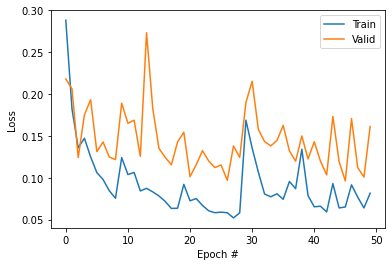

In [35]:
# plot the training loss
plt.figure()
plt.plot(train_loss_history, label="Train")
plt.plot(valid_loss_history, label="Valid")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

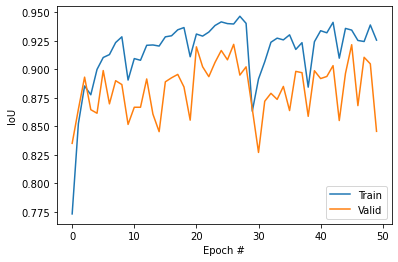

In [36]:
plt.figure()
plt.plot(train_iou_history, label="Train")
plt.plot(valid_iou_history, label="Valid")
# plt.title("Training IoU")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower right")
plt.show()

## Prediction

In [37]:
model_best = models.segmentation.fcn_resnet101(pretrained=True)
model_best.classifier = FCNHead(2048, outChannel)
model_best = model_best.to(device)
checkpoint = torch.load(f'{config["model"]}_best.ckpt')
model_best.load_state_dict(checkpoint["model_state_dict"])
model_best.eval()
total_test_iou = 0

for (x, y) in tqdm(test_loader):
    
    (x, y) = (x.to(device), y.to(device))
    
    outputs = model_best(x)
    pred = torch.sigmoid(outputs['out'])                
    iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
    total_test_iou += iou
    
test_iou = total_test_iou / test_steps
print("Test IoU:", test_iou)

100%|██████████| 10/10 [00:01<00:00,  9.11it/s]

Test IoU: tensor(0.9364, device='cuda:0')


In [38]:
def visualization(originImage, originMask, predMask, iou):
  
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    
    ax[0].imshow(originImage)
    ax[1].imshow(originMask)
    ax[2].imshow(predMask)
    
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    t = ax[2].text(170, 20, f'IoU = {iou:.3f}')
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white'))
   
    figure.tight_layout()
    figure.show()

<Figure size 720x576 with 0 Axes>

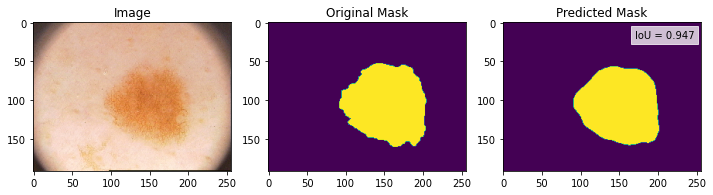

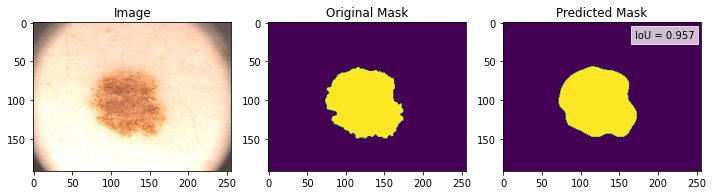

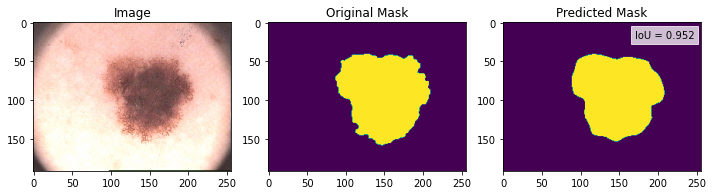

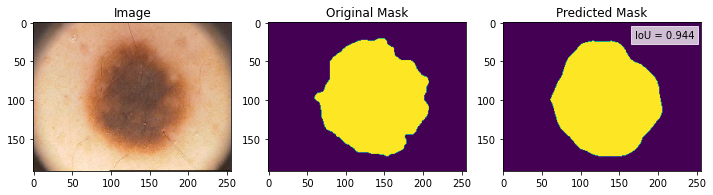

In [39]:
threshold = 0.5
fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i in range(4):
    img, mask = test_set[i]
    (img, mask) = (img.to(device), mask.to(device))
    # plt.imshow(img.permute(1,2,0))
    # plt.imshow(mask.permute(1,2,0))
    outputs = model_best(img.unsqueeze(0))
    pred = torch.sigmoid(outputs['out'])                
    iou = jaccard_index(pred, mask.type(torch.int8), num_classes=2)
    pred_mask = (pred > threshold).float()*1

    origin_img = img.permute(1,2,0).cpu().detach().numpy()
    origin_mask = mask.permute(1,2,0).cpu().detach().numpy()
    pred_mask = pred_mask.squeeze(0).permute(1,2,0).cpu().detach().numpy()
    
    
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    visualization(origin_img, origin_mask, pred_mask, iou)